In [1]:
import numpy as np
import pandas as pd

from tools import *

from homework2 import GaussianMixture
from homework3 import GaussianHMM

# Data visualization

In [2]:
data_train = pd.read_csv('EMGaussian.data', sep=' ', header=None)
data_train.columns=['x', 'y']
data_test = pd.read_csv('EMGaussian.test', sep=' ', header=None)
data_test.columns=['x', 'y']

K = 4
eps = 1e-3
covariance_mode = 'general'

# import the results of the previous homework
gaussian_mixture = GaussianMixture(data_train.values, K, covariance_mode, eps=eps)
gaussian_mixture.fit()

means, covs = gaussian_mixture.mus.T, gaussian_mixture.sigmas

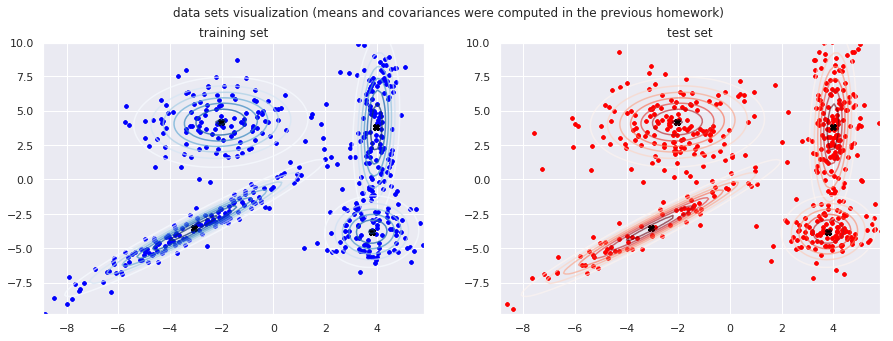

In [3]:
plot_gaussian_mixture(data_train, data_test, means, covs);

# Hidden Markov model

## Parameters learning

In [4]:
a, pi = initialize_random_parameters(K)
mu = np.copy(means)
sigma = np.copy(covs)
gaussian_hmm = GaussianHMM(a, pi, mu, sigma)
gaussian_hmm.learn_parameters(data_train.values, tol=eps, max_iter=100, verbose=True)

step: 0, log likelihood: -2364.935232159076
step: 1, log likelihood: -1922.96078323651
step: 2, log likelihood: -1900.8351236592248
step: 3, log likelihood: -1897.34293558718
step: 4, log likelihood: -1896.8724602424672
step: 5, log likelihood: -1896.803922472935
step: 6, log likelihood: -1896.7940285986815
step: 7, log likelihood: -1896.7926447421307
step: 8, log likelihood: -1896.7924535163977


## Comparing HMM and GMM

In [5]:
# computing the sequence of more likely states for HMM and GMM on both datasets
hmm_train_states = gaussian_hmm.decode(data_train.values).astype('int')
hmm_test_states = gaussian_hmm.decode(data_test.values).astype('int')

gmm_train_states = gaussian_mixture.predict(data_train.values).astype('int')
gmm_test_states = gaussian_mixture.predict(data_test.values).astype('int')

data_train_copy = data_train.copy()

data_train_copy['states_hmm'] = pd.Series(hmm_train_states)
data_train_copy['states_gmm'] = pd.Series(gmm_train_states)

data_test_copy = data_test.copy()

data_test_copy['states_hmm'] = pd.Series(hmm_test_states)
data_test_copy['states_gmm'] = pd.Series(gmm_test_states)

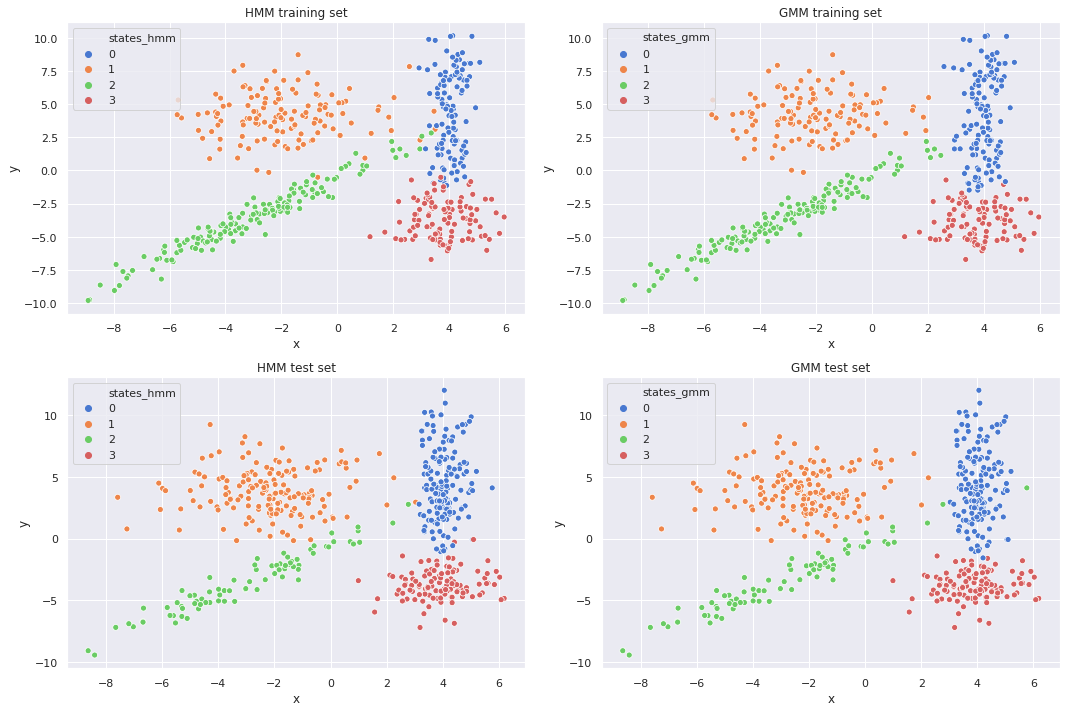

In [6]:
plot_hidden_states(data_train_copy, data_test_copy, K)

In [7]:
evaluate_models(data_train, data_test, gaussian_hmm, gaussian_mixture)

HMM log likelihood (training set) : -1896.79
HMM log likelihood (test set) : -1955.19

GMM log likelihood (training set) : -2327.72
GMM log likelihood (test set) : -2409.05


## Influence of shuffling the data

In [8]:
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

In [9]:
a, pi = initialize_random_parameters(K)
mu = np.copy(means)
sigma = np.copy(covs)
gaussian_hmm = GaussianHMM(a, pi, mu, sigma)
gaussian_hmm.learn_parameters(data_train.values, tol=eps, max_iter=100, verbose=True)

step: 0, log likelihood: -2405.9610253886126
step: 1, log likelihood: -2325.198238948764
step: 2, log likelihood: -2323.447977495114
step: 3, log likelihood: -2323.101140648726
step: 4, log likelihood: -2322.907938310793
step: 5, log likelihood: -2322.776828047271
step: 6, log likelihood: -2322.685573211313
step: 7, log likelihood: -2322.6217908463186
step: 8, log likelihood: -2322.577131499952
step: 9, log likelihood: -2322.5458016084312
step: 10, log likelihood: -2322.5237718713947
step: 11, log likelihood: -2322.50824172733
step: 12, log likelihood: -2322.4972641020718
step: 13, log likelihood: -2322.4894833794115
step: 14, log likelihood: -2322.48395365496
step: 15, log likelihood: -2322.480013174555
step: 16, log likelihood: -2322.4771976845095
step: 17, log likelihood: -2322.4751805800875
step: 18, log likelihood: -2322.4737314739136
step: 19, log likelihood: -2322.4726874340263
step: 20, log likelihood: -2322.471932954239


In [10]:
# computing the sequence of more likely states for HMM and GMM on both datasets
hmm_train_states = gaussian_hmm.decode(data_train.values).astype('int')
hmm_test_states = gaussian_hmm.decode(data_test.values).astype('int')

gmm_train_states = gaussian_mixture.predict(data_train.values).astype('int')
gmm_test_states = gaussian_mixture.predict(data_test.values).astype('int')

data_train_copy = data_train.copy()

data_train_copy['states_hmm'] = pd.Series(hmm_train_states)
data_train_copy['states_gmm'] = pd.Series(gmm_train_states)

data_test_copy = data_test.copy()

data_test_copy['states_hmm'] = pd.Series(hmm_test_states)
data_test_copy['states_gmm'] = pd.Series(gmm_test_states)

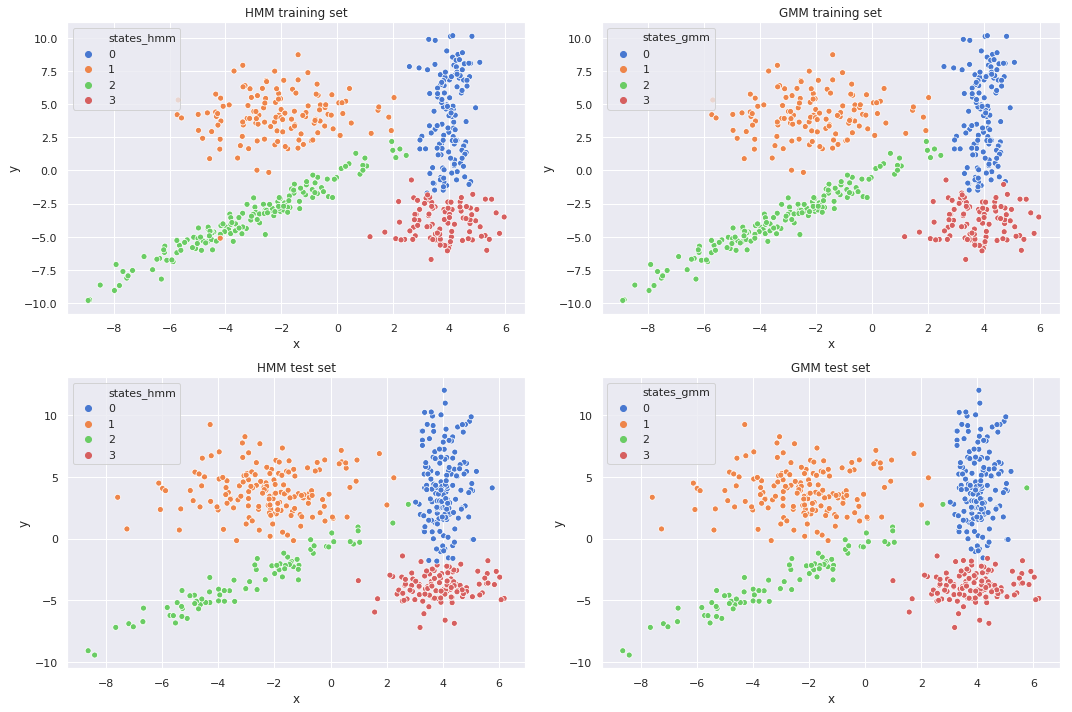

In [11]:
plot_hidden_states(data_train_copy, data_test_copy, K)

In [12]:
evaluate_models(data_train, data_test, gaussian_hmm, gaussian_mixture)

HMM log likelihood (training set) : -2322.47
HMM log likelihood (test set) : -2425.16

GMM log likelihood (training set) : -2327.72
GMM log likelihood (test set) : -2409.05


## Influence of the initialization

In [13]:
n_test = 10
mus = np.zeros((n_test, *means.shape))
sigmas = np.zeros((n_test, *covs.shape))
logas  =   np.zeros((n_test, *a.shape))
logpis = np.zeros((n_test, *pi.shape))

for step in range(n_test):
    mu = np.copy(means)
    sigma = np.copy(covs)
    a, pi = initialize_random_parameters(K)
    gaussian_hmm = GaussianHMM(a, pi, mu, sigma)
    gaussian_hmm.learn_parameters(data_train.values, tol=eps, max_iter=100, verbose=False)
    
    mus[step] = gaussian_hmm.mu
    sigmas[step] = gaussian_hmm.sigma
    logas[step] = gaussian_hmm.log_a
    logpis[step] = gaussian_hmm.log_pi

In [14]:
print(mus.std(axis=0)/mus.mean(axis=0))

[[ 2.37268797e-04  5.27768404e-03]
 [-2.17970830e-05  1.75462773e-05]
 [-2.05409213e-04 -1.65848583e-04]
 [ 9.05166923e-05 -1.76951639e-03]]


In [15]:
print(sigmas.std(axis=0)/sigmas.mean(axis=0))

[[[2.61223272e-03 1.82586122e-02]
  [1.82586122e-02 7.11738269e-03]]

 [[7.86603506e-05 1.49927748e-03]
  [1.49927748e-03 2.81513747e-05]]

 [[5.05618828e-04 4.81138421e-04]
  [4.81138421e-04 4.32332048e-04]]

 [[3.15266714e-03 1.29721866e-02]
  [1.29721866e-02 7.36550788e-03]]]


In [18]:
print(np.exp(logas).std(axis=0)/np.exp(logas).mean(axis=0))

[[4.05024035e-03 3.05491484e-04 1.81175352e-04 5.75650447e-03]
 [2.68757176e-03 8.25280339e-06 1.79270453e-05 3.18229589e-03]
 [3.82075971e-03 4.16139440e-05 2.54990994e-04 5.90381171e-03]
 [2.01049801e-03 1.54639637e-03 1.02967363e-03 5.31271860e-03]]


In [34]:
pis = np.exp(logpis)
pis[np.where(pis < 1e-5)] = 0.0
print(pis)

[[0.         0.         0.         0.99999989]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.99999999]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]]
